<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

- **BOYENVAL Thibaut**
- **AHMAD Alaë**
- **BOUT Nathan**

In [89]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (4.8, 3.2)
import urllib
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

from math import exp, sqrt, log, pi, sin, cos, atan, tan
import math
import cmath
from cmath import exp as cexp
from cmath import sqrt as csqrt
from cmath import log as clog
from cmath import phase as phase
from cmath import polar as polar

from functools import partial
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.model_selection import train_test_split

import scipy
from scipy import optimize, stats
from scipy.optimize import minimize

from random import gauss, uniform
from tqdm.notebook import tqdm

from scipy.special import gamma as gamma_func
import mpmath as mp #with special hypergeometric functions
from scipy.special import hyp2f1 as hyp_2f1

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings 
warnings.filterwarnings('ignore') #to suppress warning messages
import itertools

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Simulation of X  </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p>

We will use a recursive scheme :

We define the process 

$$
\widetilde X_t^{i} = \frac{e^{\kappa_i t}}{\eta_i}X_t^{i} = \int_0^t e^{\kappa_i s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}}^{i} = \widetilde X_{t_j}^{i} + \int_{t_{j}}^{t_{j+1}}e^{\kappa_i s} dW_s =  \
    \widetilde X_{t_j}^{i}+\sqrt{\frac{e^{2 \kappa_i t_{j+1}}-e^{2 \kappa_i t_{j}}}{2\kappa_i}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}^{i}$ and then convert back to $X_t^{i}$ by:

$$
 X_t^{i} = \eta_i e^{-\kappa_i t} \widetilde X_t^{i}.
$$

In [36]:
def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [37]:
xi, kappa_1, eta_1, eta_2, rho = 0.1, 20, 15, 2, -0.7
kappa_2 = 2.6

T = 2
n_steps = 1000
N_sims = 50

In [38]:
dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

In [39]:
np.random.seed(42)
w1=gen_bm_path(n_steps,N_sims)

In [40]:
exp1_1 = np.exp(kappa_1*tt[1:])
exp2_1 = np.exp(2*kappa_1*tt)

diff_exp2_1 = np.diff(exp2_1)
std_vec_1 = np.sqrt(diff_exp2_1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise
exp1_1 = exp1_1[:,np.newaxis]
Xt_1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(eta_1/exp1_1)*np.cumsum(std_vec_1*w1, axis = 0)))


exp1_2 = np.exp(kappa_2*tt[1:])
exp2_2 = np.exp(2*kappa_2*tt)

diff_exp2_2 = np.diff(exp2_2)
std_vec_2 = np.sqrt(diff_exp2_2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_2 = exp1_2[:,np.newaxis]
Xt_2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(eta_2/exp1_2)*np.cumsum(std_vec_2*w1, axis = 0)))

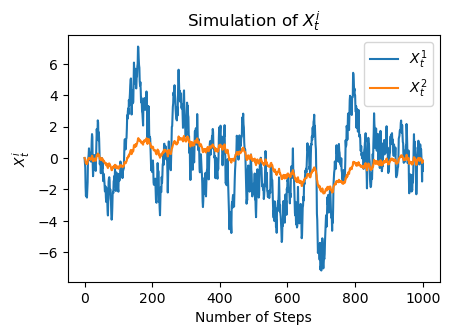

In [41]:
i_ind = 10
plt.plot(Xt_1[:,i_ind],label='$X_t^{1}$')
plt.plot(Xt_2[:,i_ind],label='$X_t^{2}$')
plt.xlabel('Number of Steps')
plt.ylabel('$X_t^{i}$')
plt.title('Simulation of $X_t^{i}$')
plt.legend()
plt.show()

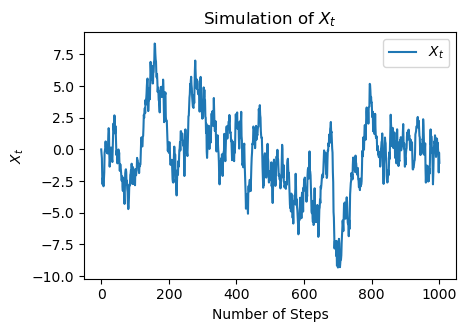

In [42]:
Xt = Xt_1 + Xt_2
plt.plot(Xt[:,i_ind],label='$X_t$')
plt.xlabel('Number of Steps')
plt.ylabel('$X_t$')
plt.title('Simulation of $X_t$')
plt.legend()
plt.show()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Simulation of $V$ and $S$ </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

We use $\mathbb V[(X_t^1+X_t^2)] = \mathbb V[X_t^1] + \mathbb V[X_t^2] + 2\mathbb {COV}[X_t^1,X_t^2]$

We have $\mathbb {COV}[X_t^1,X_t^2] = \mathbb E[X_t^1 X_t^2] = \mathbb{E}\left[\left(\eta_1\int_0^t e^{-\kappa_1(t-s)} dW_s\right)\left(\eta_2\int_0^t e^{-\kappa_2(t-s)} dW_s\right)\right] = \eta_1 \eta_2 \int_0^t e^{-(\kappa_1 + \kappa_2)(t-s)} ds = \eta_1\eta_2 \frac{1 - e^{-(\kappa_1 + \kappa_2)t}}{\kappa_1 + \kappa_2}$

In [43]:
drift_1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
drift_2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
drift_12 = 2*eta_1*eta_2*(1-np.exp(-(kappa_1 + kappa_2)))/(kappa_1 + kappa_2)

drift = drift_1 + drift_2 + drift_12

Vt = xi*np.exp(Xt-0.5*drift[:,np.newaxis])

In [44]:
S0 = 100
np.random.seed(111)
w2=gen_bm_path(n_steps,N_sims)

We simulate $\log S$ with Euler Maruyama scheme:

$$
\log S_{t_{i+1}} = \log S_{t_i}-\frac{1}{2}V_{t_i}(t_{i+1}-t_{i}) + \sqrt{(t_{i+1}-t_{i})V_{t_i}} \left(\rho \mathcal{N} +  \sqrt{(1-\rho^2)}\mathcal{N}^{\perp}\right),
$$

with $\mathcal{N}$ and $\mathcal{N}^{\perp}$ standard independent Gaussian

In [45]:
S = np.zeros((n_steps + 1, N_sims))
S[0, :] = S0  

for j in range(n_steps):
    dB = rho * w1[j] + np.sqrt(1 - rho**2) * w2[j]  
    S[j + 1, :] = S[j, :] + S[j, :] * np.sqrt(Vt[j] * dt) * dB

In [46]:
log_S = np.ones(N_sims).reshape(1,-1)*log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+sqrt(1-rho**2)*w2[j])
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

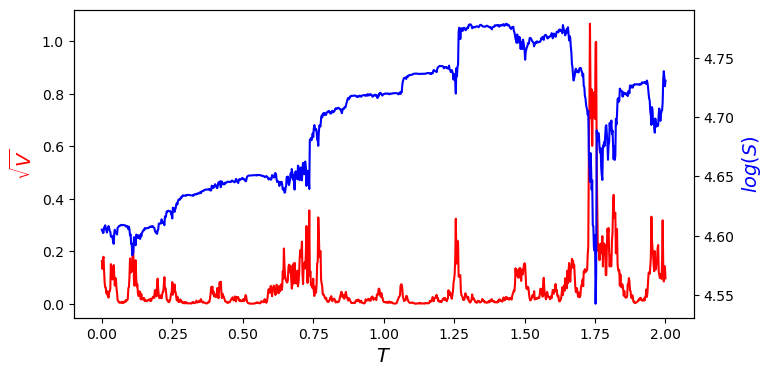

In [47]:
i_ind = 5
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(log_S[:,i_ind]), '-b',label = r'$log(S)$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$log(S)$', color='blue',size=14)
plt.show()

We can summarize all the process with one function:

In [48]:
def generate_prices(xi, kappa_1, eta_1, eta_2, rho, T, strikes, N_sims, n_steps):
    
    np.random.seed(None) # Seed unfixed to have more variability in the generation of the prices

    dt = T/n_steps
    tt = np.linspace(0., T, n_steps + 1)
    w1=gen_bm_path(n_steps, N_sims)
    
    exp1_1 = np.exp(kappa_1*tt[1:])
    exp2_1 = np.exp(2*kappa_1*tt)

    diff_exp2_1 = np.diff(exp2_1)
    std_vec_1 = np.sqrt(diff_exp2_1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_1 = exp1_1[:,np.newaxis]
    Xt_1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(eta_1/exp1_1)*np.cumsum(std_vec_1*w1, axis = 0)))


    exp1_2 = np.exp(kappa_2*tt[1:])
    exp2_2 = np.exp(2*kappa_2*tt)

    diff_exp2_2 = np.diff(exp2_2)
    std_vec_2 = np.sqrt(diff_exp2_2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_2 = exp1_2[:,np.newaxis]
    Xt_2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(eta_2/exp1_2)*np.cumsum(std_vec_2*w1, axis = 0)))
    
    Xt = Xt_1 + Xt_2
    
    drift_1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1) 
    drift_2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
    drift_12 = 2*eta_1*eta_2*(1-np.exp(-(kappa_1 + kappa_2)))/(kappa_1 + kappa_2)

    drift = drift_1 + drift_2 + drift_12

    Vt = xi*np.exp(Xt-0.5*drift[:,np.newaxis])
    
    S0 = 100
    w2=gen_bm_path(n_steps,N_sims)
    
    S_T = np.zeros((n_steps + 1, N_sims))
    S_T[0, :] = S0  

    for j in range(n_steps):
        dB = rho * w1[j] + np.sqrt(1 - rho**2) * w2[j]  
        S_T[j + 1, :] = S_T[j, :] + S_T[j, :] * np.sqrt(Vt[j] * dt) * dB
    
    prices = np.array([np.mean(np.maximum(0, S_T - K)) for K in strikes])  # Compute option prices for all strikes

    return prices

Note : Here we compute the prices for all strikes at once to reduce repetitive computations. We could also do the same to compute prices for multiple maturities in one go (by simulating the largest path and finding in tt the index closest to each maturity T), but then the computation would be less precise for small maturities. Besides, the generation is already fast enough like this.

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Simulation of the dataset </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

In [49]:
S0 = 100
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0])

In [50]:
def generation_data(num_samples):
    N_sims = 50
    n_steps = 100
    # These two numbers need to be small if we want to be able to generate a large number of data, but we may lose precision...
    data = np.zeros((num_samples, 5 + len(strikes) * len(maturities)))
    
    for i in range(num_samples):
        # Randomly generate parameters 
        xi = np.random.uniform(0.03, 0.25)
        kappa_1 = np.random.uniform(10, 60)
        eta_1 = np.random.uniform(5, 35)
        eta_2 = np.random.uniform(1, 5)
        rho = np.random.uniform(-0.9, -0.1)
        
        data[i, :5] = [xi, kappa_1, eta_1, eta_2, rho]

        for j, T in enumerate(maturities):
            prices = generate_prices(xi, kappa_1, eta_1, eta_2, rho, T, strikes, N_sims, n_steps)
            data[i, 5 + j*len(strikes):5 + (j+1)*len(strikes)] = prices
                
    return data


In [51]:
# nombre_echantillons = 1000000
# raw_data = generation_data(nombre_echantillons)
# np.save('raw_data.npy', raw_data)
raw_data = np.load('raw_data.npy')

In [52]:
raw_data.shape

(1000000, 93)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Data preprocessing </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

In [57]:
#xi,eta,kappa,rho
def print_params(x):
    print('xi = ' + str(x[0]),'\n','kappa_1 = ' + str(x[1]),'\n', 'eta_1 = ' + str(x[2]),'\n','eta_2 = ' + str(x[3]),'\n','\n','rho = ' + str(x[4]),'\n' )

In [58]:
X=raw_data[:,:5]
target_y=raw_data[:,5:]
print('X shape:', X.shape)
print('Y shape:', target_y.shape)
# 5 params + 88 option prices (11 prices for each 8 maturities slice by slice starting from shortest maturity:)

X shape: (1000000, 5)
Y shape: (1000000, 88)


In [60]:
raw_data[420]

array([ 1.28595760e-01,  5.50252332e+01,  1.31538037e+01,  2.72152499e+00,
       -8.57816084e-01,  5.08810229e+01,  4.08810229e+01,  3.08810229e+01,
        2.11270413e+01,  1.16541593e+01,  3.28690329e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.75969739e+01,  3.79969739e+01,  2.86885233e+01,  1.95983371e+01,
        1.17245503e+01,  5.36082919e+00,  1.28423630e+00,  1.52455045e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.31319065e+01,
        4.36160903e+01,  3.47979684e+01,  2.63502517e+01,  1.84188450e+01,
        1.13706288e+01,  6.19521016e+00,  3.63763037e+00,  3.03356689e+00,
        2.83356689e+00,  2.63356689e+00,  4.92446399e+01,  4.04004325e+01,
        3.17730158e+01,  2.37351932e+01,  1.64695699e+01,  9.71351068e+00,
        4.91966249e+00,  2.27776428e+00,  7.63941742e-01,  3.04639497e-01,
        4.48515704e-03,  5.27224009e+01,  4.36321546e+01,  3.48419242e+01,
        2.65435136e+01,  

In [61]:
print_params(X[102])

xi = 0.1279553499849284 
 kappa_1 = 31.959132487886396 
 eta_1 = 24.809293734397034 
 eta_2 = 2.697554035110863 
 
 rho = -0.26556418495756406 



In [62]:
#splitting the data to training and testing set
X_indexed = np.concatenate((np.arange(X.shape[0])[np.newaxis].T,X),axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, target_y, test_size=0.15, random_state=42)

train_index = X_train[:,0].astype(int)
test_index = X_test[:,0].astype(int)
X_train = X_train[:,1:]
X_test = X_test[:,1:]

#Normalising input data x to the interval of [-1, 1]
def input_norm_transform(x, x_min, x_max, norm_min, norm_max):
    return (x-x_min)/(x_max-x_min)*(norm_max-norm_min)+norm_min
def input_norm_transform_inv(x_norm, x_min, x_max, norm_min, norm_max):
    return (x_norm-norm_min)/(norm_max-norm_min)*(x_max-x_min)+x_min

x_max = np.array([0.25,  60,  35, 5, -0.1])
x_min = np.array([0.03, 10, 5, 1, -0.9])
x_norm_min = -1
x_norm_max = 1

x_train_transform = input_norm_transform(X_train, x_min, x_max, x_norm_min, x_norm_max)
x_test_transform = input_norm_transform(X_test, x_min, x_max, x_norm_min, x_norm_max)

#Standardising output data y to the interval, so it is centered with variance 1
def output_norm_transform(y, mean, std):
    return (y-mean)/std
def output_norm_transform_inv(y_trans, mean, std):
    return y_trans*std+mean

y_mean = np.average(y_train,axis=0)
y_std = np.std(y_train,axis=0)

y_train_transform = output_norm_transform(y_train, y_mean, y_std)
y_test_transform = output_norm_transform(y_test, y_mean, y_std)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Building the neural networks </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

In [67]:
model_iv = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=(5,)),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(y_train_transform.shape[1], activation="linear")
]    
)

model_iv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 30)                180       
                                                                 
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 88)                2728      
                                                                 
Total params: 4768 (18.62 KB)
Trainable params: 4768 (18.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
#RMSE error function
def error_function(y_true, y_pred):
        return tf.sqrt(tf.math.reduce_mean((y_pred - y_true)**2))

In [69]:
model_iv.compile(optimizer="adam", loss=error_function)

In [70]:
train_hist=model_iv.fit(x_train_transform,  y_train_transform, batch_size=128, epochs=50)

Epoch 1/50
6641/6641 [==============================] - 13s 2ms/step - loss: 0.5867
Epoch 2/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5843
Epoch 3/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5852
Epoch 4/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5851
Epoch 5/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5842
Epoch 6/50
6641/6641 [==============================] - 13s 2ms/step - loss: 0.5847
Epoch 7/50
6641/6641 [==============================] - 13s 2ms/step - loss: 0.5849
Epoch 8/50
6641/6641 [==============================] - 13s 2ms/step - loss: 0.5844
Epoch 9/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5850
Epoch 10/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5845
Epoch 11/50
6641/6641 [==============================] - 12s 2ms/step - loss: 0.5847
Epoch 12/50
6641/6641 [==============================] - 12s 2ms/step - lo

In [90]:
# Saving the weights
# model_iv.save_weights('2FBergomiNNWeights.h5')

model_iv.load_weights('2FBergomiNNWeights.h5')

In [91]:
# Transfering the learned NN to numpy

NNParameters=[]
for i in range(0,len(model_iv.layers)):
    NNParameters.append(model_iv.layers[i].get_weights())

NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(5)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Validating Neural Networks results </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

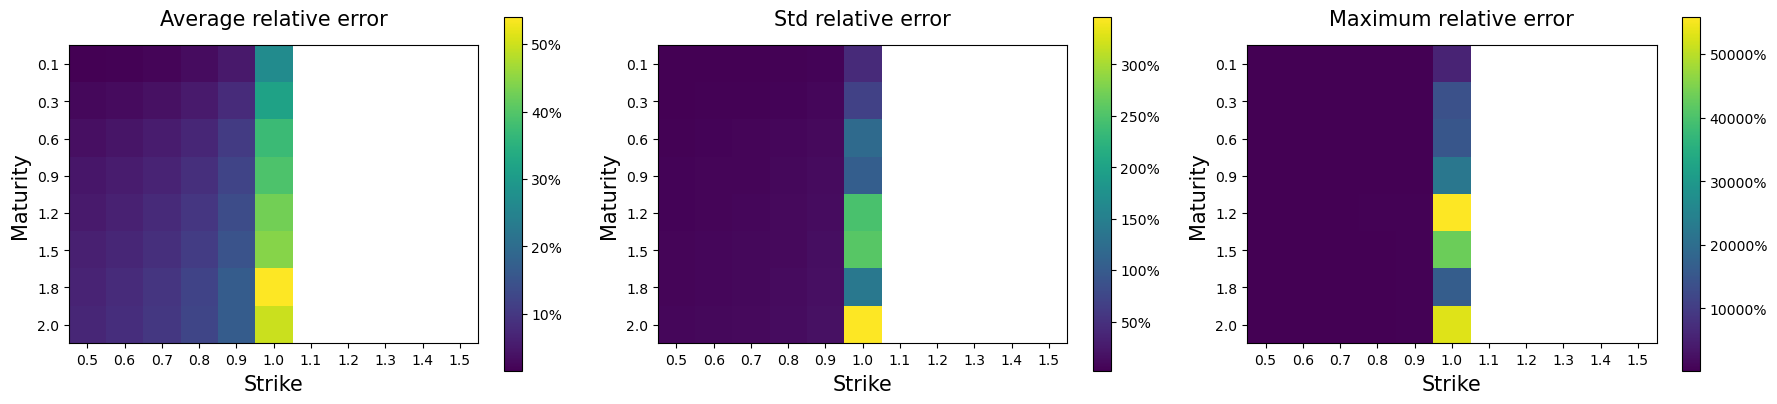

In [92]:
### Checking the training set ###

y_pred=output_norm_transform_inv(NeuralNetwork(x_train_transform), y_mean, y_std)

strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_train-y_pred)/y_train),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.show()

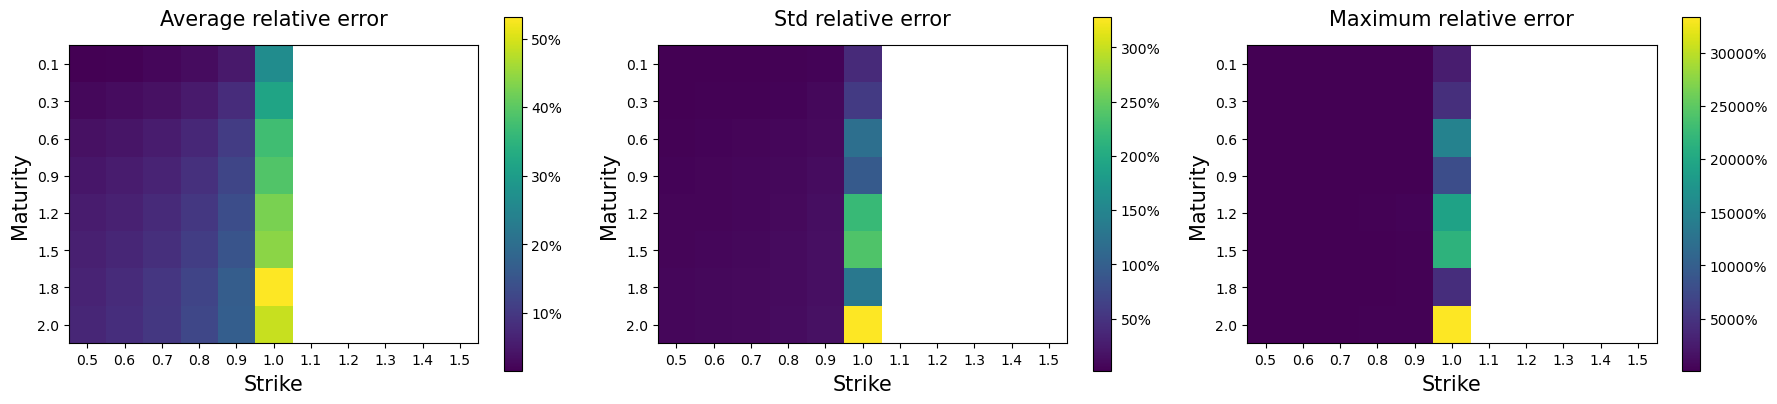

In [93]:
### Checking the test set ###

y_pred=output_norm_transform_inv(NeuralNetwork(x_test_transform), y_mean, y_std)

strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_test-y_pred)/y_test),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes/100)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.show()

xi = 0.052874677167679664 
 kappa_1 = 32.380768227818336 
 eta_1 = 23.695115504464642 
 eta_2 = 2.6449360258465906 
 
 rho = -0.22676581692658127 



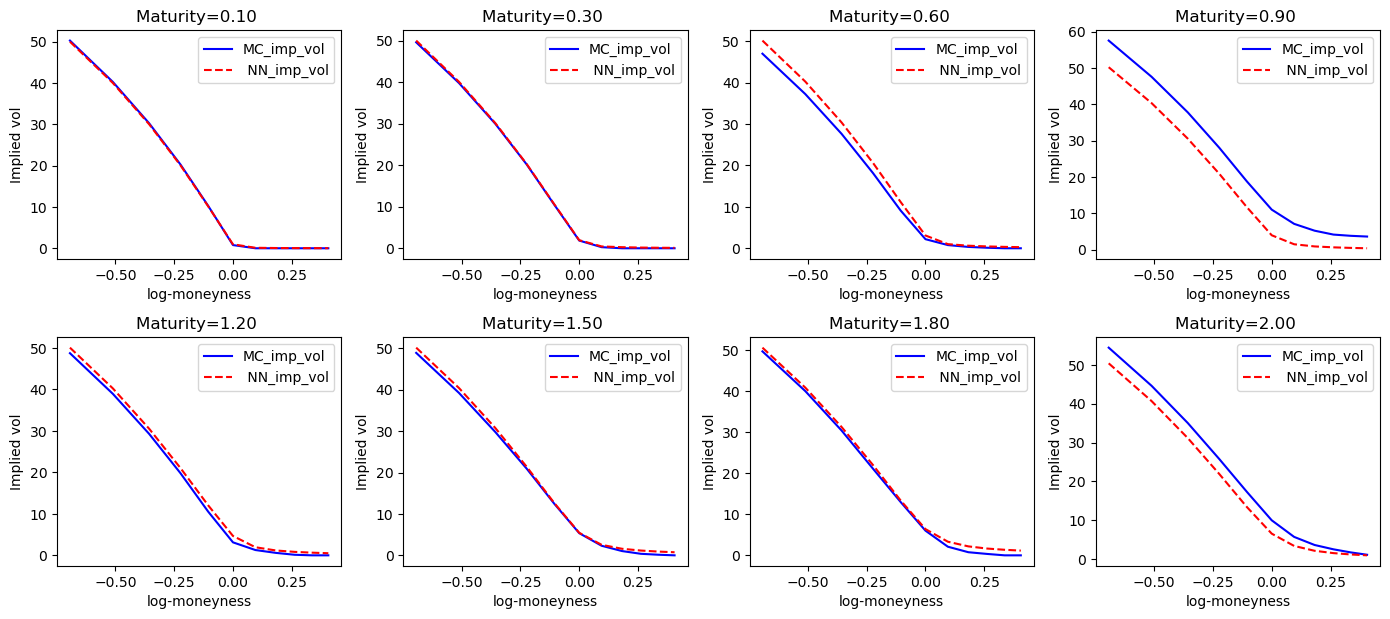

In [94]:
sample_ind= 100
X_input = X_test[sample_ind]
X_input_transform = input_norm_transform(X_input, x_min, x_max, x_norm_min, x_norm_max)
y_true = y_test[sample_ind]
print_params(X_input)

prediction=output_norm_transform_inv(NeuralNetwork(X_input_transform), y_mean, y_std)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_true[i*strikes_dim:(i+1)*strikes_dim],'b',label="MC_imp_vol")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN_imp_vol")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

In [95]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(xi0,kappa_1, eta_1, eta_2,rho):
    x0 = input_norm_transform(np.array([xi0,kappa_1, eta_1, eta_2,rho]), x_min, x_max, x_norm_min, x_norm_max)
    Smiles = output_norm_transform_inv(NeuralNetwork(x0).reshape(1,-1), y_mean, y_std)
    plt.figure(1,figsize=(14,12))
    for i in range(8):
        plt.subplot(4,4,i+1)

        
        plt.plot(np.log(strikes/S0),Smiles[0,i*strikes_dim:(i+1)*strikes_dim],'b',label=" NN Approx")

        #plt.ylim(0.1,0.8)
        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
                                               min=0.03,
                                               max=0.25,
                                               step=0.01),
        kappa_1 = widgets.FloatSlider(value=2.5,
                                               min=10,
                                               max=60,
                                               step=0.1),
        eta_1 = widgets.FloatSlider(value=1,
                                               min=5,
                                               max=35,
                                               step=0.1),
        eta_2 = widgets.FloatSlider(value=1,
                                               min=1,
                                               max=35,
                                               step=0.1),
        rho = widgets.FloatSlider(value=-0.6,
                                               min=-0.9,
                                               max=-0.1,
                                               step=0.05))


interactive(children=(FloatSlider(value=0.04, description='xi0', max=0.25, min=0.03, step=0.01), FloatSlider(v…

<function __main__.plot_func(xi0, kappa_1, eta_1, eta_2, rho)>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Calibrate to SPX volatility surface 5/12/2017 </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

In [96]:
spx_surface = np.array(pd.read_csv('spx_surface.csv',header=None)).reshape(-1)

In [97]:
def CostFuncLS(x):
    spx_transform = output_norm_transform(spx_surface, y_mean, y_std)
    return (NeuralNetwork(x)-spx_transform)
def JacobianLS(x):
    return NeuralNetworkGradient(x).T
init=np.zeros(X.shape[1])
opt_res = scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1e-15)
print(opt_res)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.506e+01  3.665e+01 ...  2.203e-01  4.576e-01]
           x: [-3.411e+00 -9.656e-01 -1.114e+01 -3.657e+00  3.156e+01]
        cost: 2672.954990837988
         jac: [[-2.525e-02  5.243e-04 ... -1.937e-03  1.226e-02]
               [-4.458e-02 -9.869e-03 ...  2.580e-03  7.929e-03]
               ...
               [ 5.229e-01 -2.151e-02 ...  8.118e-02 -8.493e-03]
               [ 4.845e-01 -1.809e-02 ...  6.797e-02 -3.400e-03]]
        grad: [-5.342e-04 -1.596e-03  4.368e-03 -2.841e-03 -5.970e-03]
  optimality: 0.005970177804151546
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 90
        njev: 76


In [98]:
calib_params = input_norm_transform_inv(opt_res.x, x_min, x_max, x_norm_min, x_norm_max)
print_params(calib_params)

xi = -0.23519929737307707 
 kappa_1 = 10.860310227199005 
 eta_1 = -147.032386563865 
 eta_2 = -4.3137015002016215 
 
 rho = 12.12518786801183 



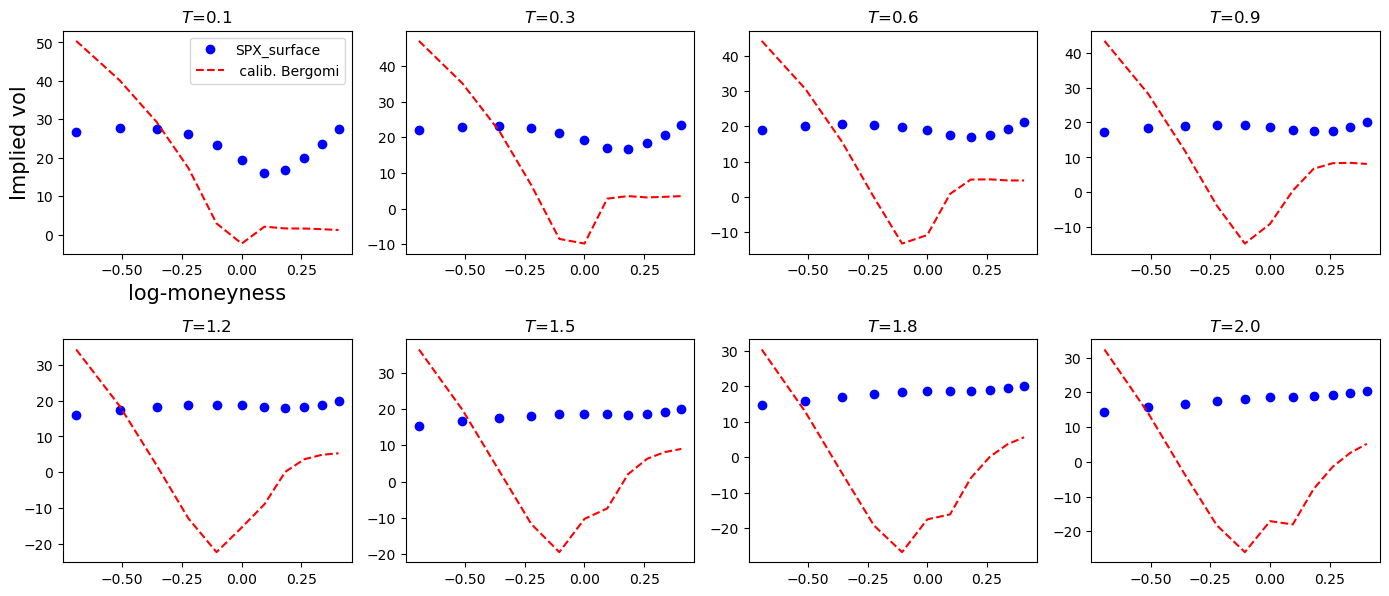

In [99]:
calib_surface=output_norm_transform_inv(NeuralNetwork(opt_res.x), y_mean, y_std)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),strikes*spx_surface[i*strikes_dim:(i+1)*strikes_dim],color='b',marker='o', linestyle='',label="SPX_surface")
    plt.plot(np.log(strikes/S0),calib_surface[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" calib. Bergomi")
    plt.title(r"$T$=%1.1f "%maturities[i])

    if i ==0:
        plt.legend()
        plt.xlabel("log-moneyness",size=15)
        plt.ylabel("Implied vol",size=15)
plt.tight_layout()
plt.show()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> Prices for the given sets of parameters </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

# Sample IV surface values

In [100]:
params = np.array([
    [0.06, 41.6, 18.2428, 3.43, -0.7],
    [0.1, 15.6, 5.5857, 2.2867, -0.4],
    [0.2, 54.6, 31.3496, 4.5733, -0.8]
])

In [101]:
params_normalized = input_norm_transform(params, x_min, x_max, x_norm_min, x_norm_max)

In [102]:
predicted_prices_normalized = model_iv.predict(params_normalized)

1/1 [==============================] - 0s 50ms/step


In [103]:
predicted_prices = output_norm_transform_inv(predicted_prices_normalized, y_mean, y_std)

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

In [104]:
print(predicted_prices[0])

[ 5.00148733e+01  4.00339742e+01  3.00710475e+01  2.01519421e+01
  1.03700491e+01  1.47423655e+00  3.09706578e-02  1.61709256e-02
  4.97141104e-03  6.10402897e-04 -7.33491457e-04  5.00850128e+01
  4.01674975e+01  3.03109817e+01  2.05793536e+01  1.11407847e+01
  2.81280674e+00  2.37846199e-01  8.32273386e-02  4.86389657e-02
  2.66919599e-02  1.40408095e-02  5.02597748e+01  4.04262040e+01
  3.07062436e+01  2.11930244e+01  1.21085579e+01  4.25514420e+00
  9.24823881e-01  3.40154795e-01  2.16625011e-01  1.57288307e-01
  1.15959510e-01  5.04003798e+01  4.06558933e+01  3.10697642e+01
  2.17487372e+01  1.29503122e+01  5.44113338e+00  1.71732613e+00
  7.00979145e-01  4.11591832e-01  2.97970253e-01  2.34333627e-01
  5.03287671e+01  4.06703009e+01  3.12039534e+01  2.20620346e+01
  1.35205563e+01  6.31382461e+00  2.38097412e+00  1.02954036e+00
  5.68596965e-01  3.85686657e-01  2.91595515e-01  5.05210463e+01
  4.09464573e+01  3.16066193e+01  2.26437093e+01  1.43391779e+01
  7.36563698e+00  3.29549

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

In [105]:
print(predicted_prices[1])

[ 4.99795371e+01  3.99924766e+01  3.00345718e+01  2.01708645e+01
  1.06739964e+01  2.89987635e+00  3.15995775e-01  5.13247420e-02
  1.30290699e-02  3.15216834e-03 -2.18308616e-04  5.00947021e+01
  4.02193212e+01  3.04801625e+01  2.10465085e+01  1.23180863e+01
  5.31367863e+00  1.67550364e+00  5.84497592e-01  2.57589397e-01
  1.43365545e-01  9.16582586e-02  5.03983806e+01  4.07154807e+01
  3.12974996e+01  2.23610529e+01  1.42987113e+01  7.81285033e+00
  3.69632062e+00  1.78131571e+00  9.42876645e-01  5.54039420e-01
  3.59855199e-01  5.05568696e+01  4.10601811e+01  3.19243059e+01
  2.33723027e+01  1.57627729e+01  9.60825780e+00  5.31685508e+00
  2.91937575e+00  1.66101123e+00  9.99878686e-01  6.40984409e-01
  5.08477446e+01  4.15489154e+01  3.26948292e+01  2.45111703e+01
  1.72985316e+01  1.14243320e+01  7.06513596e+00  4.34389720e+00
  2.74043644e+00  1.79420014e+00  1.22835073e+00  5.10473971e+01
  4.19331459e+01  3.33268251e+01  2.54403243e+01  1.85336834e+01
  1.28552531e+01  8.48100

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

In [106]:
print(predicted_prices[2])

[5.00432228e+01 4.00879683e+01 3.01588102e+01 2.02765390e+01
 1.05024561e+01 1.37899188e+00 9.20009894e-02 3.71700537e-02
 2.01569187e-02 1.30465137e-02 9.68242369e-03 5.01902946e+01
 4.03184555e+01 3.05101197e+01 2.08147317e+01 1.13507525e+01
 2.79181093e+00 5.01882874e-01 2.67679650e-01 1.59623197e-01
 1.05046403e-01 7.49897519e-02 5.04558690e+01 4.06781262e+01
 3.10061173e+01 2.15064796e+01 1.23479350e+01 4.26213975e+00
 1.33161398e+00 8.21550642e-01 6.02165271e-01 4.54994090e-01
 3.56155228e-01 5.05712546e+01 4.08890433e+01 3.13491239e+01
 2.20230161e+01 1.31132451e+01 5.36730583e+00 2.07790515e+00
 1.29451498e+00 9.84216307e-01 7.87166623e-01 6.47404617e-01
 5.06213747e+01 4.10304896e+01 3.16055573e+01 2.24462183e+01
 1.37840134e+01 6.36993191e+00 2.87578468e+00 1.83840856e+00
 1.41489513e+00 1.16098781e+00 9.74330045e-01 5.07853506e+01
 4.12739131e+01 3.19593416e+01 2.29539270e+01 1.44977872e+01
 7.31545456e+00 3.68600049e+00 2.42948868e+00 1.89833598e+00
 1.59253790e+00 1.371331

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018